# Possion Image Editing

In [1]:
# Improt libraries
import matplotlib.pyplot as plt
import cv2
import scipy
import scipy.sparse as sps
import numpy as np


## Task1 Grayscale Image Simple Interpolation

* Load and Dispaly Images and Masks

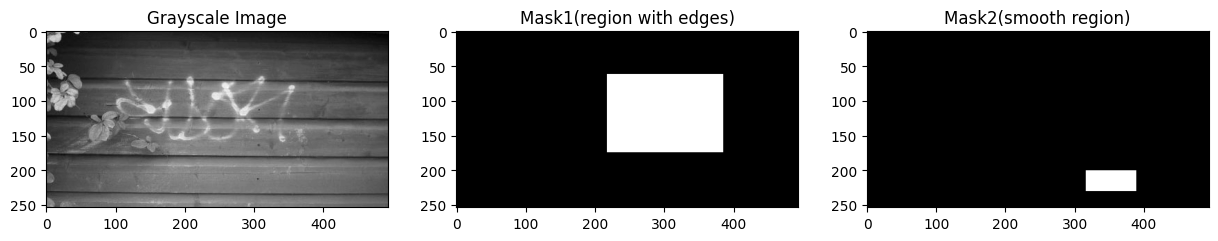

(254, 494, 3)
(254, 494)
(254, 494)


In [2]:
#Load Images and Masks
img1_path = "images/test1.png"
mask1_path = "images/test1_mask1.png"
mask2_path = "images/test1_mask2.png"

img1 = cv2.imread(img1_path)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

mask1 = cv2.imread(mask1_path, cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)

# Display Image and Masks
# Mask1 refers to region with edges
# Mask2 refers to smooth region
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img1_gray, cmap='gray')
axs[0].set_title('Grayscale Image')
axs[1].imshow(mask1, cmap='gray')
axs[1].set_title('Mask1(region with edges)')
axs[2].imshow(mask2, cmap='gray')
axs[2].set_title('Mask2(smooth region)')
plt.show()

#check the size of images
print(img1.shape)
print(mask1.shape)
print(mask2.shape)

* Simple Interpolation

    Now, I will perform simple interpolation in the region 
where the mask is located, assuming a gradient of 0 for the pixels to be interpolated.


In [3]:
# Build matrix A, A is a sparse matrix
def buildMatA(mask, numNeighbor=4):
    h, w = mask.shape
    maskPixels = np.where(mask)
    idx_map = np.full((h, w), -1)
    idx_map[maskPixels] = np.arange(len(maskPixels[0]))
    
    num_maskPixels = len(maskPixels[0])
    
    #initialize matrix A
    #A = np.zeros((num_maskPixels, num_maskPixels))
    A = scipy.sparse.lil_matrix((num_maskPixels, num_maskPixels))
    
    # Set diagonal elements to 4
    #np.fill_diagonal(A, numNeighbor)
    
    for i, j in zip(*maskPixels): 
            pixel_idx = idx_map[i, j]
            A[pixel_idx, pixel_idx] = numNeighbor
            neighbors = [(i, j - 1), (i, j + 1), (i - 1, j), (i + 1, j)]
            for ni, nj in neighbors:
                 if 0 <= ni < h and 0 <= nj < w and mask[ni, nj]:
                      A[pixel_idx, idx_map[ni, nj]] = -1       
            
           
    A = sps.csr_matrix(A)
    return A

In [4]:
# Build vector b for simple interpolation 
def buildVecBSimple(destImg, mask):
    h, w = mask.shape
    maskPixels = np.where(mask)
    idx_map = np.full((h, w), -1)
    idx_map[maskPixels] = np.arange(len(maskPixels[0]))
    
    num_maskPixels = (len(maskPixels[0]))
    #initialize vector b    
    b = np.zeros(num_maskPixels)
    
    for i, j in zip(*maskPixels): 
            pixel_idx = idx_map[i, j]
            neighbors = [(i, j - 1), (i, j + 1), (i - 1, j), (i + 1, j)]
            for ni, nj in neighbors:
                 if 0 <= ni < h and 0 <= nj < w and not mask[ni, nj]:
                      b[pixel_idx] += destImg[ni, nj]
    return b

In [5]:
# Solve the linear equation Af=b, which is a sparse equation
def solveAfequalsB(A, b):
    f = sps.linalg.spsolve(A, b)
    f = np.clip(f, 0, 255)    
    return f

In [6]:
# Fill in the new pixel value
def fillPixelValue(mask, f, destImg):
    mask_coords = np.column_stack(np.where(mask))    
    imgNew = destImg.copy()
    for idx, (i, j) in enumerate(mask_coords):
        imgNew[i, j] = f[idx]
    return imgNew

In [7]:
def simpleInterpolate(mask, destImg):
    A = buildMatA(mask)
    b = buildVecBSimple(destImg, mask)

    f = solveAfequalsB(A, b)
    result = fillPixelValue(mask, f, destImg)
    return result

* TEST

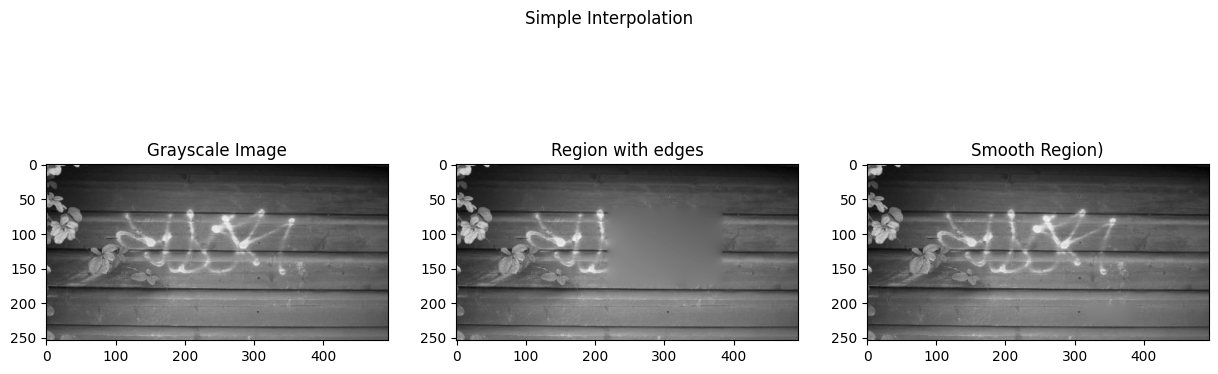

In [8]:
img1_simpleInterpolation1 = simpleInterpolate(mask1, img1_gray)
img1_simpleInterpolation2 = simpleInterpolate(mask2, img1_gray)

# Display the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('Simple Interpolation')

axs[0].imshow(img1_gray, cmap='gray')
axs[0].set_title('Grayscale Image')
axs[1].imshow(img1_simpleInterpolation1, cmap='gray')
axs[1].set_title('Region with edges')
axs[2].imshow(img1_simpleInterpolation2, cmap='gray')
axs[2].set_title('Smooth Region)')
plt.show()



**Report**

* The results indicate that simple interpolation performs well in smooth regions but tends to smooth out edges in areas with many edges, affecting the visual appearance, similar to applying a mosaic effect.
* The larger the selected region, the less the pixels inside the filled area are influenced by the boundary pixels.

## Task2 Grayscale Image Seamless Cloning

* Load and Didplay Images and Mask.

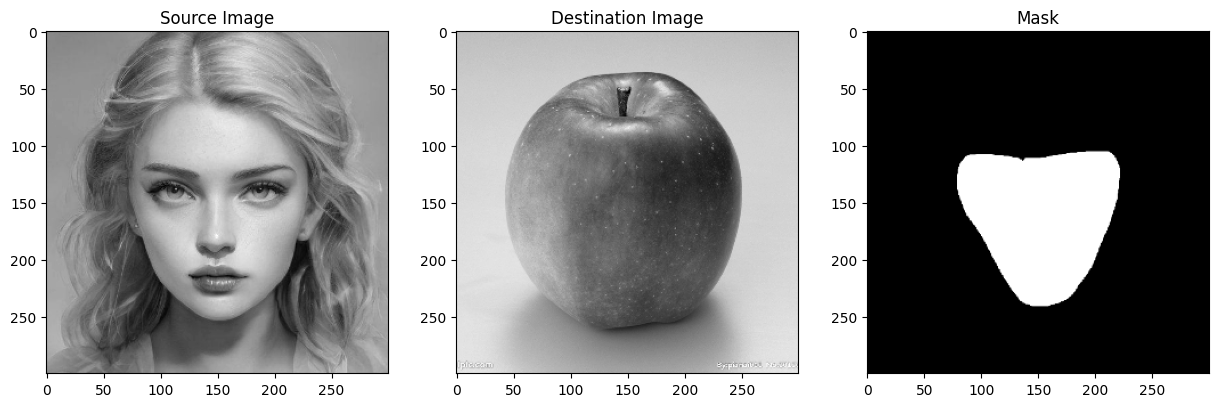

In [9]:
# Load images and mask
img2_path = 'images/test2.png'
img3_path = 'images/face1.png'
mask3_path = 'images/face1_mask.png'

img2 = cv2.imread(img2_path)
img2 = cv2.resize(img2, (300, 300))
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img3 = cv2.imread(img3_path)
img3 = cv2.resize(img3, (300, 300))
img3_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

mask3 = cv2.imread(mask3_path, cv2.IMREAD_GRAYSCALE)
mask3 = cv2.resize(mask3, (300, 300))



fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display images and mask
axs[0].imshow(img3_gray, cmap='gray')
axs[0].set_title('Source Image')
axs[1].imshow(img2_gray, cmap='gray')
axs[1].set_title('Destination Image')
axs[2].imshow(mask3, cmap='gray')
axs[2].set_title('Mask')
plt.show()


* Grayscale Image Seamless Cloning

In [10]:
# Build Constraint vector b
def buildVecBSeamless(srcImg, destImg, mask, mode='importing'):
    h, w = mask.shape
    maskPixels = np.where(mask)
    idx_map = np.full((h, w), -1)
    idx_map[maskPixels] = np.arange(len(maskPixels[0]))
    
    num_maskPixels = len(maskPixels[0])
    #initialize vector b    
    b = np.zeros(num_maskPixels)
    
    for i, j in zip(*maskPixels): 
            pixel_idx = idx_map[i, j]
            neighbors = [(i, j - 1), (i, j + 1), (i - 1, j), (i + 1, j)]
            for ni, nj in neighbors:
                if mode == 'importing':
                    diff = srcImg[i, j].astype(np.float32) - srcImg[ni, nj].astype(np.float32)
                if mode == 'mixing':
                    diff1 = srcImg[i, j].astype(np.float32) - srcImg[ni, nj].astype(np.float32)
                    diff2 = destImg[i, j].astype(np.float32) - destImg[ni, nj].astype(np.float32)  
                    diff = diff1 if abs(diff1) > abs(diff2) else diff2
                b[pixel_idx] += diff
                if not mask[ni, nj]:
                      b[pixel_idx] += destImg[ni, nj]
    return b

In [11]:
def seamlessCloning(mask, srcImg, destImg, mode='importing'):
    A = buildMatA(mask)
    b = buildVecBSeamless(srcImg, destImg, mask, mode)

    f = solveAfequalsB(A, b)
    result = fillPixelValue(mask, f, destImg)
    return result

* TEST

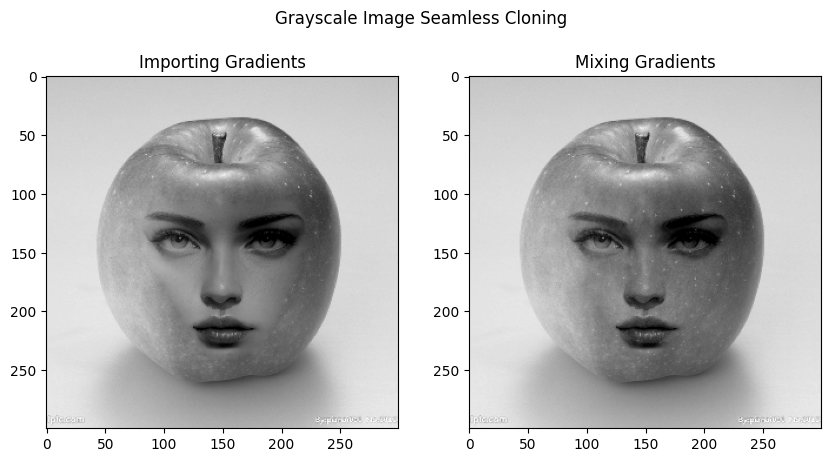

In [12]:
img_seamless1 = seamlessCloning(mask3, img3_gray, img2_gray)
img_seamless2 = seamlessCloning(mask3, img3_gray, img2_gray, mode='mixing')

# Display results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle('Grayscale Image Seamless Cloning')

# Display images and mask
axs[0].imshow(img_seamless1, cmap='gray')
axs[0].set_title('Importing Gradients')
axs[1].imshow(img_seamless2, cmap='gray')
axs[1].set_title('Mixing Gradients')

plt.show()



## Task3 Color Image Seamless Cloning

* Load and Display Images and Mask

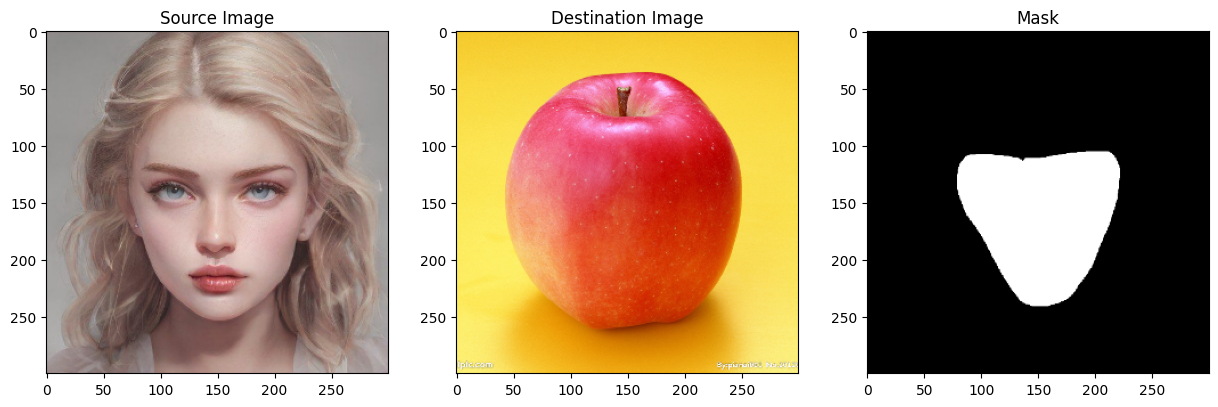

In [13]:
#Display images and mask
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display images and mask
axs[0].imshow(img3_rgb)
axs[0].set_title('Source Image')
axs[1].imshow(img2_rgb)
axs[1].set_title('Destination Image')
axs[2].imshow(mask3, cmap='gray')
axs[2].set_title('Mask')
plt.show()

* Color Image Seamless Cloning

In [14]:
# seamless cloning in colorspace
def seamlessCloningRGB(mask, srcImg, destImg, mode='importing'):
    A = buildMatA(mask)

    result = destImg.copy()

    for c in range(srcImg.shape[2]):
        b = buildVecBSeamless(srcImg[:, :, c], destImg[:, :, c], mask, mode)
        f = solveAfequalsB(A, b)
        result_channel = fillPixelValue(mask, f, destImg[:, :, c])
        result[:, :, c] = result_channel

    return result

* TEST

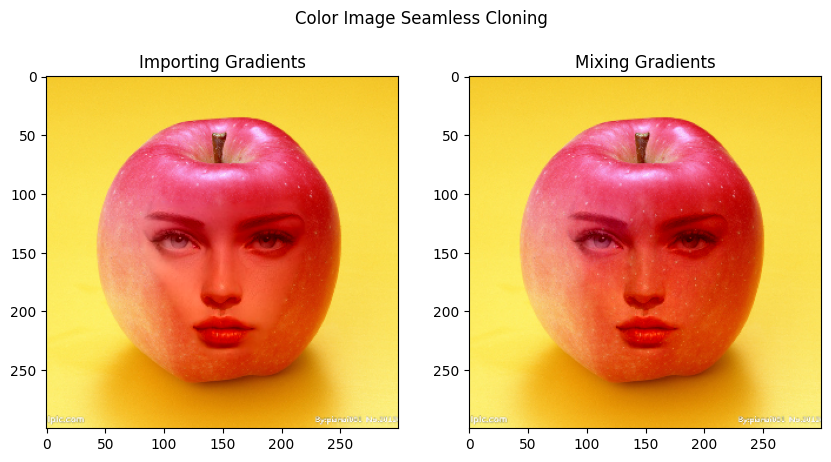

In [15]:
img_seamless_rgb1 = seamlessCloningRGB(mask3, img3_rgb, img2_rgb, mode='importing')
img_seamless_rgb2 = seamlessCloningRGB(mask3, img3_rgb, img2_rgb, mode='mixing')

# Display images and mask
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle('Color Image Seamless Cloning')

axs[0].imshow(img_seamless_rgb1)
axs[0].set_title('Importing Gradients')
axs[1].imshow(img_seamless_rgb2)
axs[1].set_title('Mixing Gradients')

plt.show()



## Task4

* Local color changes

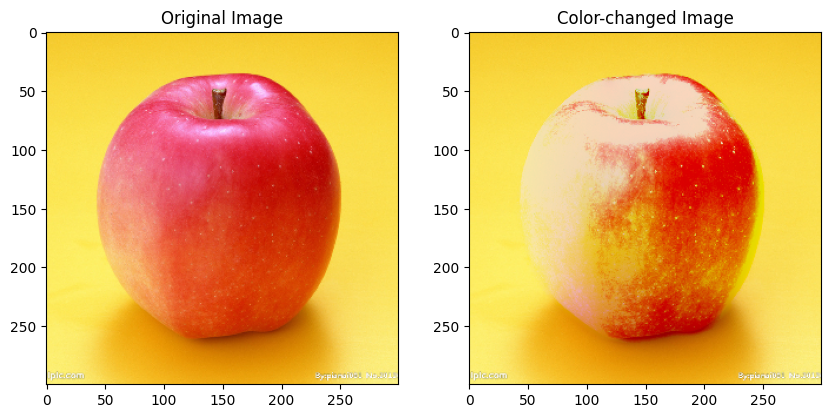

In [16]:
# Load mask4 for the apple in img2
mask4_path = 'images/test2_mask.png'

mask4 = cv2.imread(mask4_path, cv2.IMREAD_GRAYSCALE)
mask4 = cv2.resize(mask4, (300, 300))

#Change color
factor = [0.5, 3.0, 2.0]
img2_newRgb = img2_rgb.copy()
img2_newRgb = img2_newRgb * factor
img2_newRgb = np.clip(img2_newRgb, 0, 255)

img_colorChange = seamlessCloningRGB(mask4, img2_newRgb, img2_rgb)

#Display Results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img2_rgb)
axs[0].set_title('Original Image')
axs[1].imshow(img_colorChange)
axs[1].set_title('Color-changed Image')

plt.show()